<a href="https://colab.research.google.com/github/AilsaBeatrice77/Brain_Stroke_Classification/blob/main/Salinan_dari_Ai_bio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brain Stroke Detection from CT Scan Using 3D CNN**
## *Comparing The Performance with Different Segmentation*

## **Dataset**

Dataset yang digunakan berasal dari Kaggle (https://www.kaggle.com/datasets/jillanisofttech/brain-stroke-dataset) yang berisi potongan-potongan CT Scan 82 pasien. Dari data 82 pasien tersebut sudah dibagi antara data orang normal dan data pasien Brain Stroke (51 Normal, 31 Brain Stroke).

In [ ]:
import os
import zipfile
import tensorflow as tf

with zipfile.ZipFile("archive.zip", "r") as z_fp:
    z_fp.extractall(".")

In [ ]:
!ls -al Brain_Data_Organised

total 96
drwxr-xr-x 4 root root  4096 Sep 22 06:00 .
drwxr-xr-x 1 root root  4096 Sep 22 09:32 ..
drwxr-xr-x 2 root root 53248 Sep 22 06:00 Normal
drwxr-xr-x 2 root root 36864 Sep 22 06:00 Stroke


In [ ]:
!ls Brain_Data_Organised/Normal | head

100 (10).jpg
100 (11).jpg
100 (12).jpg
100 (13).jpg
100 (14).jpg
100 (15).jpg
100 (16).jpg
100 (17).jpg
100 (18).jpg
100 (19).jpg


In [ ]:
!ls Brain_Data_Organised/Stroke | head

58 (10).jpg
58 (11).jpg
58 (12).jpg
58 (13).jpg
58 (15).jpg
58 (17).jpg
58 (18).jpg
58 (19).jpg
58 (1).jpg
58 (20).jpg


Dapat dilihat bahwa dataset berisi beberapa potongan gambar (.jpg) untuk setiap pasiennya. Potongan-potongan tersebut juga tidak tersimpan dengan urut dan ada beberapa potongan gambar yang hilang. Berikut kode untuk membagi CT Scan tiap pasien menjadi plot 4x10 atau 40 potong per pasien sesuai dengan urutan potongan CT Scan di dataset asli.

In [ ]:
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import numpy as np

def plot_scan_from_path(slices_path, patient_id):
    num_rows = 4
    num_columns = 10
    factor = 1.2
    f, axarr = plt.subplots(
        num_rows,
        num_columns,
        figsize=(num_columns*factor, num_rows*factor),
    )
    f.suptitle(f"Patient {patient_id}", y=1.1)
    image_id = 1
    for i in range(num_rows):
        for j in range(num_columns):
          try:
            img = imageio.imread(f'{slices_path}/{patient_id} ({image_id}).jpg')
          except Exception as e:
            print(e)
            img = np.zeros((2,2))
          finally:
            axarr[i, j].imshow(img, cmap='gray')
            axarr[i, j].axis('off')
            image_id += 1
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

Sebagai contoh, dipilih pasien 49 dan pasien 50 untuk melihat bagaimana urutannya pada dataset asli.

No such file: '/content/Brain_Data_Organised/Normal/49 (34).jpg'
No such file: '/content/Brain_Data_Organised/Normal/49 (35).jpg'
No such file: '/content/Brain_Data_Organised/Normal/49 (36).jpg'
No such file: '/content/Brain_Data_Organised/Normal/49 (37).jpg'
No such file: '/content/Brain_Data_Organised/Normal/49 (38).jpg'
No such file: '/content/Brain_Data_Organised/Normal/49 (39).jpg'
No such file: '/content/Brain_Data_Organised/Normal/49 (40).jpg'


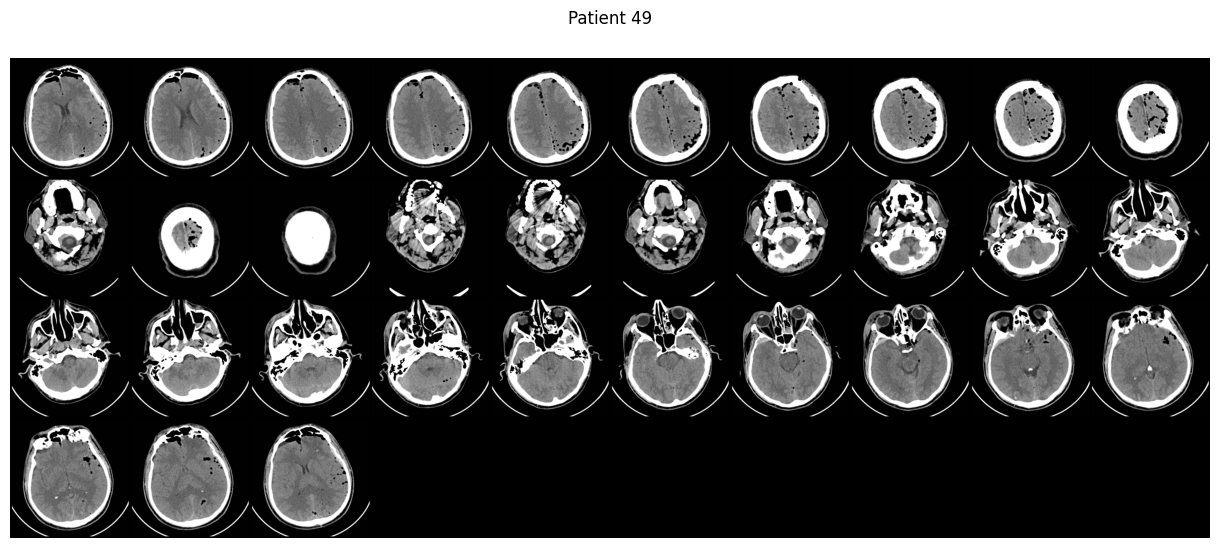

In [ ]:
plot_scan_from_path(slices_path='Brain_Data_Organised/Normal', patient_id=49)

No such file: '/content/Brain_Data_Organised/Normal/50 (13).jpg'
No such file: '/content/Brain_Data_Organised/Normal/50 (15).jpg'
No such file: '/content/Brain_Data_Organised/Normal/50 (17).jpg'
No such file: '/content/Brain_Data_Organised/Normal/50 (19).jpg'
No such file: '/content/Brain_Data_Organised/Normal/50 (21).jpg'
No such file: '/content/Brain_Data_Organised/Normal/50 (23).jpg'
No such file: '/content/Brain_Data_Organised/Normal/50 (25).jpg'
No such file: '/content/Brain_Data_Organised/Normal/50 (27).jpg'
No such file: '/content/Brain_Data_Organised/Normal/50 (29).jpg'
No such file: '/content/Brain_Data_Organised/Normal/50 (31).jpg'
No such file: '/content/Brain_Data_Organised/Normal/50 (33).jpg'
No such file: '/content/Brain_Data_Organised/Normal/50 (35).jpg'
No such file: '/content/Brain_Data_Organised/Normal/50 (39).jpg'
No such file: '/content/Brain_Data_Organised/Normal/50 (40).jpg'


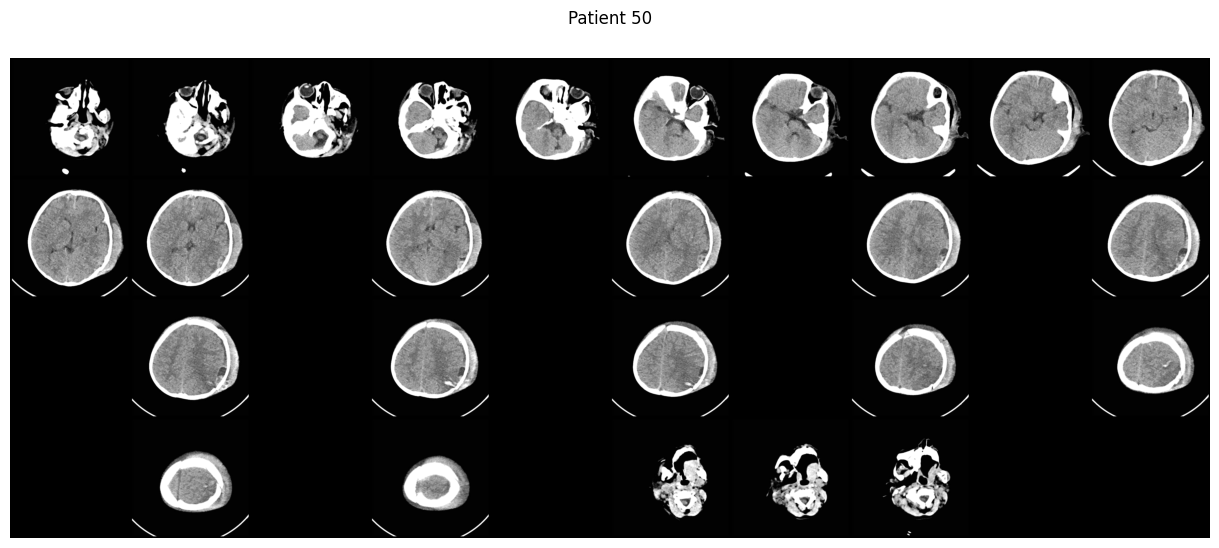

In [ ]:
plot_scan_from_path(slices_path='Brain_Data_Organised/Normal', patient_id=50)

Dapat dilihat pada pasien 49, gambar CT Scan pertama merupakan dari otak bagian tengah. Sedangkan pada pasien 50, juga terdapat beberapa potongan CT Scan yang hilang. Hal tersebut membuat import dan pengolahan dataset menjadi lebih sulit.

## **Dataset Fixing**

Pada website Kaggle terdapat kode untuk memperbaiki dan mengurutkan data secara manual. Saya menggunakan kode tersebut untuk memperbaiki data dan mempermudah dalam pengolahan citra. Dataset fixing dilakukan dengan mengurutkan potongan CT Scan dengan tepat dan menghilangkan bagian-bagian yang kosong.

In [ ]:
INPUT_PATH='Brain_Data_Organised'
OUTPUT_PATH='brain_ct_data_fixed'
NORMAL_INPUT_PATH=f'{INPUT_PATH}/Normal'
NORMAL_OUTPUT_PATH=f'{OUTPUT_PATH}/Normal'
STROKE_INPUT_PATH=f'{INPUT_PATH}/Stroke'
STROKE_OUTPUT_PATH=f'{OUTPUT_PATH}/Stroke'

NORMAL_SORTING_CONFIG = {
    49:  [14, 15, 16, 11, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13],
    50:  [36, 37, 38, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34],
    51:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50],
    52:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
    53:  [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 28, 29, 31, 33, 35, 37, 39, 41, 43, 1, 2, 3, 4],
    54:  [20, 21, 22, 23, 24, 25, 26, 27, 28, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
    55:  [30, 31, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    56:  [33, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
    57:  [32, 33, 34, 35, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
    59:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
    60:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    61:  [25, 26, 27, 28, 29, 30, 31, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
    62:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
    63:  [33, 34, 35, 36, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
    64:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
    65:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    95:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    96:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
    98:  [29, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    99:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    100: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    101: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
    102: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
    103: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
    104: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    105: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    106: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    107: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    108: [25, 26, 27, 28, 29, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24],
    109: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    110: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    111: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
    112: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26],
    113: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    114: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    115: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
    116: [31, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    117: [29, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    118: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    119: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
    120: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    121: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    122: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    123: [39, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38],
    124: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    125: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
    126: [30, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    127: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
    128: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28],
    129: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    130: [26, 27, 28, 29, 30, 31, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
}

STROKE_SORTING_CONFIG = {
    58: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36],
    66: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 38, 39, 40, 41],
    67: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 23, 25, 27, 28, 29, 30, 31, 32, 33],
    68: [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36],
    69: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36],
    70: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 42, 43, 44, 45, 46, 47, 48],
    71: [48, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46],
    72: [31, 32, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    73: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 30, 32, 34, 36, 38, 39],
    74: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 20, 22, 23, 25, 27, 29, 31, 33, 35, 37, 39, 40, 41, 42, 43, 44, 45, 46],
    75: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 49],
    76: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 40, 41, 42, 43],
    77: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43],
    78: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 17, 19, 21, 23, 25, 26, 28, 30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42],
    79: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
    80: [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 14, 15, 16, 18, 20, 22, 24, 26, 28, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40],
    81: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 44],
    82: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
    83: [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 27, 29, 31, 33, 35, 36, 37, 38, 1, 2, 3, 4],
    84: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
    85: [21, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20],
    86: [31, 32, 33, 34, 35, 36, 1, 2, 3, 4, 6, 8, 10, 12, 14, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    87: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 40, 41, 42, 43, 44],
    88: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 26, 28, 30, 32, 34, 35, 36, 37],
    89: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 23, 25, 27, 29, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43],
    90: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
    91: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 21, 23, 25, 27, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
    92: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 20, 21, 23, 25, 27, 29, 31, 32, 33, 34, 36, 38, 40, 42],
    93: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36],
    94: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 44, 45, 46],
    97: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 35, 36, 37, 38, 39, 40],
}

Selanjutnya, hanya tinggal menyalin data yang sudah diperbaiki ke path yang berbeda.

In [ ]:
import os
import shutil

def sort_slices(input_path, output_path, patient_id, order):
  """Copy the slices in the correct order"""
  # Create output folder for sorted images (if it does not exist)
  if not os.path.exists(output_path):
    os.makedirs(output_path, exist_ok=True)

  # Move the image to the output path with a name based on the correct sorting order
  for new_id in range(1, len(order)+1):
    old_id = order[new_id-1]
    shutil.copyfile(f'{input_path}{os.sep}{patient_id} ({old_id}).jpg', f'{output_path}{os.sep}{patient_id} ({new_id}).jpg')


# Normal slices sorting
for patient_id, order in NORMAL_SORTING_CONFIG.items():
    sort_slices(
      input_path=NORMAL_INPUT_PATH,
      output_path=NORMAL_OUTPUT_PATH,
      patient_id=patient_id,
      order=order)

# Stroke slices sorting
for patient_id, order in STROKE_SORTING_CONFIG.items():
    sort_slices(
      input_path=STROKE_INPUT_PATH,
      output_path=STROKE_OUTPUT_PATH,
      patient_id=patient_id,
      order=order)

Akan dilihat CT Scan pasien 49 dan 50 dengan data yang sudah diperbaiki untuk mengetahui perbedaannya dengan dataset awal yang masih belum diurutkan.

No such file: '/content/brain_ct_data_fixed/Normal/49 (34).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/49 (35).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/49 (36).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/49 (37).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/49 (38).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/49 (39).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/49 (40).jpg'


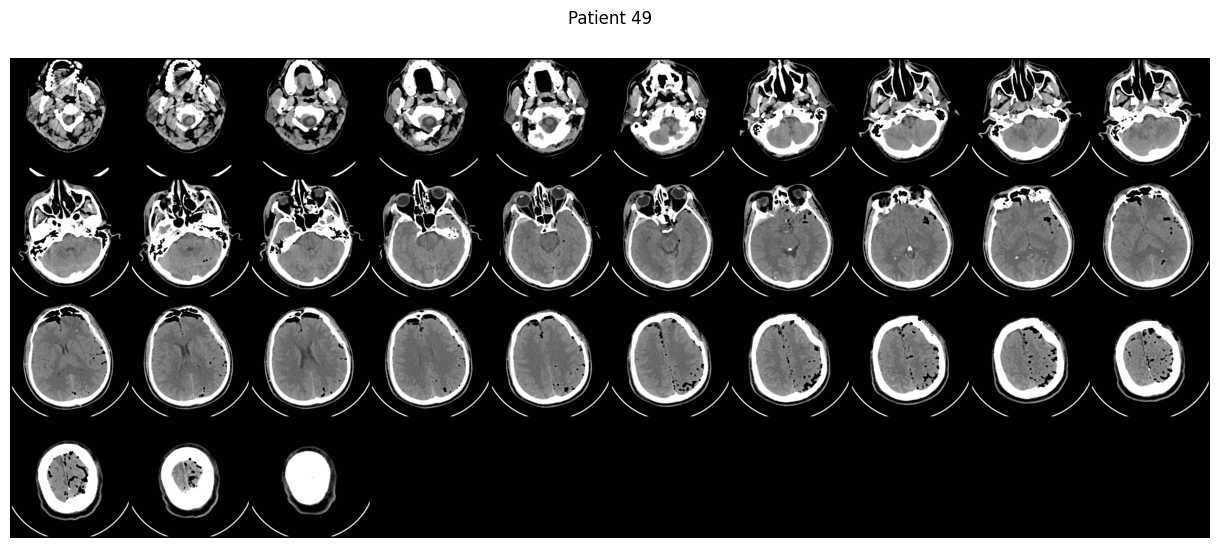

In [ ]:
plot_scan_from_path(slices_path=NORMAL_OUTPUT_PATH, patient_id=49)

No such file: '/content/brain_ct_data_fixed/Normal/50 (27).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (28).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (29).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (30).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (31).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (32).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (33).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (34).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (35).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (36).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (37).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (38).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (39).jpg'
No such file: '/content/brain_ct_data_fixed/Normal/50 (40).jpg'


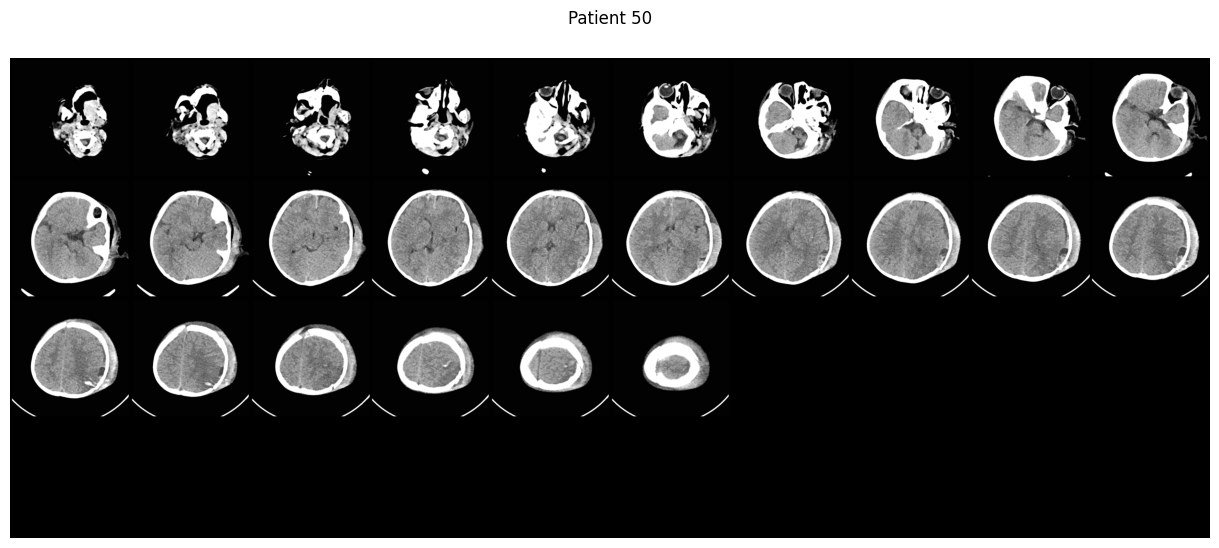

In [ ]:
plot_scan_from_path(slices_path=NORMAL_OUTPUT_PATH, patient_id=50)

Dataset yang sudah diperbaiki, diubah juga menjadi bentuk file .zip

In [ ]:
!zip -r brain_ct_data_fixed.zip brain_ct_data_fixed

updating: brain_ct_data_fixed/ (stored 0%)
updating: brain_ct_data_fixed/Stroke/ (stored 0%)
updating: brain_ct_data_fixed/Stroke/81 (12).jpg (deflated 8%)
updating: brain_ct_data_fixed/Stroke/88 (1).jpg (deflated 9%)
updating: brain_ct_data_fixed/Stroke/77 (6).jpg (deflated 6%)
updating: brain_ct_data_fixed/Stroke/89 (19).jpg (deflated 7%)
updating: brain_ct_data_fixed/Stroke/90 (3).jpg (deflated 12%)
updating: brain_ct_data_fixed/Stroke/83 (29).jpg (deflated 15%)
updating: brain_ct_data_fixed/Stroke/97 (3).jpg (deflated 8%)
updating: brain_ct_data_fixed/Stroke/74 (28).jpg (deflated 14%)
updating: brain_ct_data_fixed/Stroke/58 (14).jpg (deflated 5%)
updating: brain_ct_data_fixed/Stroke/77 (25).jpg (deflated 11%)
updating: brain_ct_data_fixed/Stroke/75 (2).jpg (deflated 14%)
updating: brain_ct_data_fixed/Stroke/67 (6).jpg (deflated 15%)
updating: brain_ct_data_fixed/Stroke/90 (13).jpg (deflated 9%)
updating: brain_ct_data_fixed/Stroke/68 (6).jpg (deflated 10%)
updating: brain_ct_data_f

## **Preprocessing**

Meski dataset sudah diurutkan dan tidak terdapat lubang pada CT Scan tiap pasien, namun masih cukup sulit untuk load_dataset karena jumlah potongan CT Scan tiap pasien yang berbeda-beda. Sehingga dataset perlu dilakukan preprocessing yaitu dengan merged potongan-potongan CT Scan tiap pasien menjadi 1 scan tiap pasien. Urutan dari preprocessing adalah sebagai berikut:

1. count_slices: menghitung jumlah potongan CT Scan tiap pasien
2. merge_slices: menggabungkan potongan-potongan CT Scan tiap pasien menjadi hanya 1 scan tiap pasien saja.
3. normalize_scan: menormalisasikan hasil scan yang sudah di merge pada interval [0, 1]
4. resize_scan: mengatur supaya ukuran dari tiap scan sama.
5. collect_scan: mengumpulkan scan lengkap dari satu pasien. Ini pertama-tama menggabungkan semua potongan, kemudian menghilangkan noise, menormalisasi, dan mengubah ukuran scan.
5. load_dataset:  mengumpulkan semua scan dari seluruh dataset CT. Ini menggunakan hasil dari count_slices untuk mengetahui berapa banyak slice yang ada untuk setiap pasien dan kemudian menggunakan collect_scan untuk mengumpulkan setiap scan.

In [ ]:
NORMAL_PATH = '/content/brain_ct_data_fixed/Normal'
STROKE_PATH = '/content/brain_ct_data_fixed/Stroke'

Berikut adalah kode untuk menghilangkan noise atau artefak dari scan.

In [ ]:
from scipy import ndimage
from skimage import morphology
import numpy as np

def remove_noise(image, display=False):
  """Remove slice noise"""
  # morphology.dilation creates a segmentation of the image
  # If one pixel is between the origin and the edge of a square of size
  # 3x3, the pixel belongs to the same class
  segmentation = morphology.dilation(image, np.ones((3, 3)))
  segmentation[segmentation < 25] = 0
  segmentation[segmentation > 25] = 1
  labels, label_nb = ndimage.label(segmentation)
  label_count = np.bincount(labels.ravel().astype(int))

  # The size of label_count is the number of classes/segmentations found.
  # The first class is not used since it's the background.
  label_count[0] = 0

  # A mask with the class with more pixels is created
  # since it should represent the brain
  mask = labels == label_count.argmax()

  # Improve the brain mask
  mask = morphology.dilation(mask, np.ones((5, 5)))
  mask = ndimage.binary_fill_holes(mask)
  mask = morphology.dilation(mask, np.ones((3, 3)))

  # Since the pixels in the mask are zeros and ones,
  # it is possible to multiple the original image to only keep the brain region
  masked_image = mask * image

  if display:
    plt.figure(figsize=(10, 2.5))
    plt.subplot(141)
    plt.imshow(image, cmap=plt.cm.bone)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(142)
    plt.imshow(mask, cmap=plt.cm.bone)
    plt.title('Mask')
    plt.axis('off')

    plt.subplot(143)
    plt.imshow(masked_image, cmap=plt.cm.bone)
    plt.title('Clean Image')
    plt.axis('off')

  return masked_image

In [ ]:
import numpy as np
from tqdm import tqdm

def count_slices(path):
  """Analyze the slices path and returns a dictionary with the slices count associated to each patient"""
  slice_dict = {}
  for dirname, _, filenames in os.walk(path):
      for filename in filenames:
        patient_id = int(filename.split()[0])
        if patient_id not in slice_dict:
          slice_dict[patient_id] = 1
        else:
          slice_dict[patient_id] = slice_dict[patient_id] + 1

  return slice_dict

def merge_slices(path, patient_id, slice_count, denoise=False):
  """Merge all the slices for a patient into a scan"""
  if denoise:
    scan = tuple(remove_noise(imageio.imread(f'{path}/{patient_id} ({slice_id}).jpg')) for slice_id in range(1, slice_count+1))
  else:
    scan = tuple(imageio.imread(f'{path}/{patient_id} ({slice_id}).jpg') for slice_id in range(1, slice_count+1))

  return np.dstack(scan)


def normalize_scan(scan):
  """Normalize the volume"""
  min = 0
  max = 255
  scan[scan < min] = min
  scan[scan > max] = max
  scan = (scan - min) / (max - min)
  scan = scan.astype("float32")
  return scan

def resize_scan(scan):
  """Resize across z-axis"""
  # Set the desired depth
  desired_depth = 64
  desired_width = 128
  desired_height = 128
  # Get current depth
  current_depth = scan.shape[-1]
  current_width = scan.shape[0]
  current_height = scan.shape[1]
  # Compute depth factor
  depth = current_depth / desired_depth
  width = current_width / desired_width
  height = current_height / desired_height
  depth_factor = 1 / depth
  width_factor = 1 / width
  height_factor = 1 / height
  # Rotate
  scan = ndimage.rotate(scan, 90, reshape=False)
  # Resize across z-axis
  scan = ndimage.zoom(scan, (width_factor, height_factor, depth_factor), order=1)
  return scan


def collect_scan(path, patient_id, slice_count):
  """Collect a scan for a patient id"""
  # Get a single CT scan by merging all the slices from a single patient
  # Before getting merged the slices are also denoised
  scan = merge_slices(path, patient_id, slice_count, denoise=True)
  # Normalize the CT scan to the interval [0, 1]
  scan = normalize_scan(scan)
  # Resize the CT scan to uniform the size
  scan = resize_scan(scan)

  return scan


def load_dataset(path):
  """Return the scans dataset as a 4D array"""
  # Get a dictionary with patient IDs and slice count per patient
  slices_dict = count_slices(path)

  # Collect scans for each patient id
  dataset = np.array([collect_scan(path, patient_id, slice_count) for patient_id, slice_count in tqdm(slices_dict.items())])

  return dataset

normal_dataset dan stroke_dataset diimport dari masing-masing path berikut.

In [ ]:
normal_dataset = load_dataset(path=NORMAL_PATH)
stroke_dataset = load_dataset(path=STROKE_PATH)


100%|██████████| 51/51 [03:38<00:00,  4.29s/it]

100%|██████████| 31/31 [02:03<00:00,  3.99s/it]


In [ ]:
normal_dataset.shape, stroke_dataset.shape

((51, 128, 128, 64), (31, 128, 128, 64))

Dataset diatas direpresentasikan dengan matriks 4D (samples, height, width, depth). Karena terdapat 51 data normal dan 31 data brain stroke, maka dataset cukup tidak seimbang. Fungsi plot_slices_from_dataset berikut dapat digunakan untuk plot semua dataset yang sudah di load sebelumnya.

In [ ]:
def plot_scan_from_dataset(num_rows, num_columns, width, height, data, title):
  """Plot a scan from dataset"""
  data = np.transpose(data)
  data = np.reshape(data, (num_rows, num_columns, width, height))
  rows_data, columns_data = data.shape[0], data.shape[1]
  heights = [slc[0].shape[0] for slc in data]
  widths = [slc.shape[1] for slc in data[0]]
  fig_width = 12.0
  fig_height = fig_width * sum(heights) / sum(widths)
  f, axarr = plt.subplots(
      rows_data,
      columns_data,
      figsize=(fig_width, fig_height),
      gridspec_kw={"height_ratios": heights},
  )
  f.suptitle(title, y=1.1)
  for i in range(rows_data):
      for j in range(columns_data):
          axarr[i, j].imshow(data[i][j], cmap="gray")
          axarr[i, j].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
  plt.show()

Berikut adalah plot dari pasien pertama normal dan pasien pertama brain stroke.

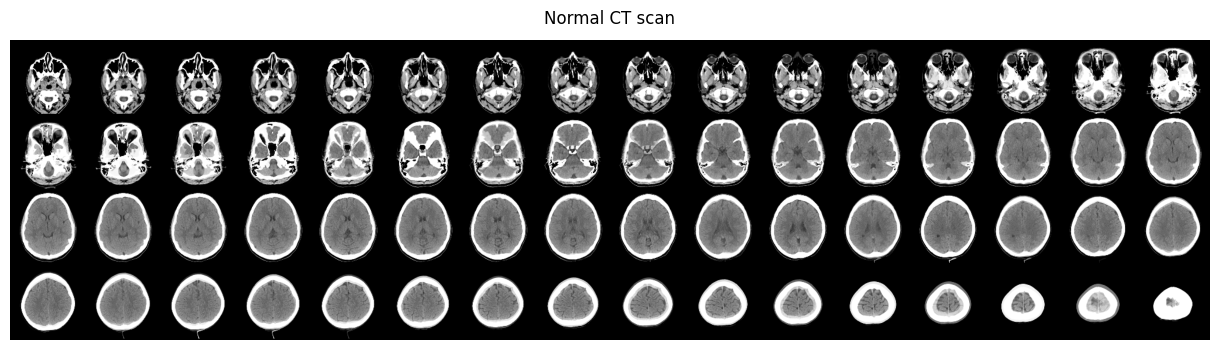

In [ ]:
plot_scan_from_dataset(4, 16, 128, 128, normal_dataset[0, :, :, :], "Normal CT scan")

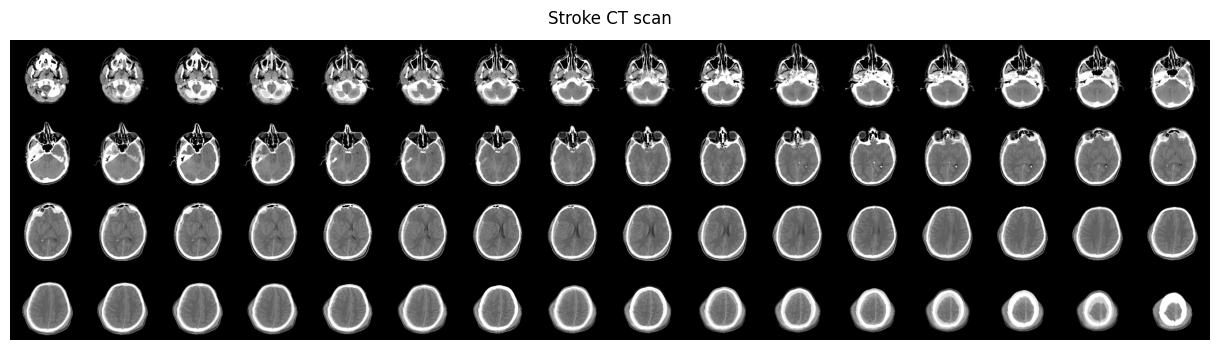

In [ ]:
plot_scan_from_dataset(4, 16, 128, 128, stroke_dataset[0, :, :, :], "Stroke CT scan")

## **Training and Validation**

Pada bagian ini, dataset yang sudah diolah di preprocessing, dibagi menjadi data training dan validation dengan ratio 7:3.

In [ ]:
normal_labels = np.array([0 for _ in range(len(normal_dataset))])
stroke_labels = np.array([1 for _ in range(len(stroke_dataset))])

import math
VALIDATION_SPLIT = 0.7
normal_train_len = math.ceil(VALIDATION_SPLIT*len(normal_labels))
stroke_train_len = math.ceil(VALIDATION_SPLIT*len(stroke_labels))
x_train = np.concatenate((normal_dataset[:normal_train_len], stroke_dataset[:stroke_train_len]), axis=0)
y_train = np.concatenate((normal_labels[:normal_train_len], stroke_labels[:stroke_train_len]), axis=0)
x_val = np.concatenate((normal_dataset[normal_train_len:], stroke_dataset[stroke_train_len:]), axis=0)
y_val = np.concatenate((normal_labels[normal_train_len:], stroke_labels[stroke_train_len:]), axis=0)

print(f"Training samples")
print(f"Normal: {normal_train_len}")
print(f"Stroke: {stroke_train_len}")
print(f"Total: {x_train.shape[0]}")
print()
print(f"Validation samples")
print(f"Normal: {len(normal_dataset) - normal_train_len}")
print(f"Stroke: {len(stroke_dataset) - stroke_train_len}")
print(f"Total: {x_val.shape[0]}")

Training samples
Normal: 36
Stroke: 22
Total: 58

Validation samples
Normal: 15
Stroke: 9
Total: 24


## **Augmentation**

In [ ]:
# Set TensorFlow random seed
tf.random.set_seed(42)

# Define data loaders
training_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

# Define batch size
batch_size = 2

# Training dataset
training_dataset = (
    training_loader.shuffle(len(x_train))
    .batch(batch_size)
    .prefetch(2)
)

# Validation dataset
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .batch(batch_size)
    .prefetch(2)
)

## **Model Definition**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Default arguments
WIDTH=128
HEIGHT=128
DEPTH=64
INITIAL_LEARNING_RATE=0.0001
DECAY_STEPS=100000
DECAY_RATE=0.96

# Performance metrics
METRICS=[
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def build_model(width=WIDTH,
                height=HEIGHT,
                depth=DEPTH,
                initial_learning_rate=INITIAL_LEARNING_RATE,
                decay_steps=DECAY_STEPS,
                decay_rate=DECAY_RATE,
                metrics=METRICS,
                augmentation=False,
                brightness=False,
                contrast=False):
  """Build a 3D convolutional neural network model with augmentation layers"""

  # Define the model
  model = keras.Sequential()
  model.add(keras.Input((width, height, depth)))

  # Augmentation layers
  if augmentation:
    if brightness:
      model.add(layers.RandomBrightness(factor=0.1, value_range=[0.0, 1.0]))
    if contrast:
      model.add(layers.RandomContrast(factor=(0, 1.2)))

  # Add a dimension to perform 3D convolutions
  model.add(layers.Reshape(target_shape=(width, height, depth, 1)))

  model.add(layers.Conv3D(filters=64, kernel_size=3, activation="relu"))
  model.add(layers.MaxPool3D(pool_size=2))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv3D(filters=64, kernel_size=3, activation="relu"))
  model.add(layers.MaxPool3D(pool_size=2))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv3D(filters=128, kernel_size=3, activation="relu"))
  model.add(layers.MaxPool3D(pool_size=2))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv3D(filters=256, kernel_size=3, activation="relu"))
  model.add(layers.MaxPool3D(pool_size=2))
  model.add(layers.BatchNormalization())

  model.add(layers.GlobalAveragePooling3D())
  model.add(layers.Dense(units=512, activation="relu"))
  model.add(layers.Dropout(0.3))

  model.add(layers.Dense(units=1, activation="sigmoid"))

  # Define the optimizer
  lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=decay_steps, decay_rate=decay_rate, staircase=True
  )

  # Compile the model
  model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=metrics,
  )

  return model

model = build_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 128, 128, 64, 1)   0         
                                                                 
 conv3d_20 (Conv3D)          (None, 126, 126, 62, 64   1792      
                             )                                   
                                                                 
 max_pooling3d_20 (MaxPooli  (None, 63, 63, 31, 64)    0         
 ng3D)                                                           
                                                                 
 batch_normalization_20 (Ba  (None, 63, 63, 31, 64)    256       
 tchNormalization)                                               
                                                                 
 conv3d_21 (Conv3D)          (None, 61, 61, 29, 64)    110656    
                                                      

## **Model Training**

In [ ]:
# Default epochs number
EPOCHS=15

# Callback
CHECKPOINT_CB = keras.callbacks.ModelCheckpoint(
    "ct-scan-brain-stroke-detection-{epoch:03d}-{val_auc:.4f}.h5",
    save_best_only=True,
    monitor='val_auc',
    mode='max'
)

# Model training function
def train_model(model, training_dataset, validation_dataset, epochs=EPOCHS, callbacks=[CHECKPOINT_CB]):
  """Train a model doing validation at the end of each epoch"""
  history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=1,
    callbacks=callbacks
  )

  return history

In [ ]:
performance = {}

In [ ]:
model = build_model(augmentation=True,
                    brightness=True,
                    contrast=True)

performance["performance"] = train_model(model, training_dataset, validation_dataset)

Epoch 1/15
29/29 [==============================] - 522s 17s/step - loss: 0.7077 - tp: 16.0000 - fp: 34.0000 - tn: 35.0000 - fn: 21.0000 - accuracy: 0.4811 - precision: 0.3200 - recall: 0.4324 - auc: 0.4222 - prc: 0.2992 - val_loss: 0.6789 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 15.0000 - val_fn: 9.0000 - val_accuracy: 0.6250 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6889 - val_prc: 0.6249
Epoch 2/15
29/29 [==============================] - 496s 17s/step - loss: 0.6858 - tp: 7.0000 - fp: 8.0000 - tn: 28.0000 - fn: 15.0000 - accuracy: 0.6034 - precision: 0.4667 - recall: 0.3182 - auc: 0.5322 - prc: 0.3920 - val_loss: 0.6645 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 15.0000 - val_fn: 9.0000 - val_accuracy: 0.6250 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5556 - val_prc: 0.5004
Epoch 3/15
29/29 [==============================] - 496s 17s/step - loss: 0.6534 - tp: 4.0000 - fp: 5.0000 - tn: 31.0000 - fn: 18.0000 - accurac